In [1]:
pip install gym

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tensorflow==1.13.2

  Using cached https://files.pythonhosted.org/packages/a9/2e/846be1aca29a5324f85b7a8cc8f1fb6eade08708118d2f466eac6a3ec518/tensorflow-1.13.2-cp37-cp37m-macosx_10_11_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/bb/48/13f49fc3fa0fdf916aa1419013bb8f2ad09674c275b4046d5ee669a46873/tensorflow_estimator-1.13.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/0f/39/bdd75b08a6fba41f098b6cb091b9e8c7a80e1b4d679a581a0ccd17b10373/tensorboard-1.13.1-py3-none-any.whl
  Found existing installation: tensorflow-estimator 2.0.1
    Uninstalling tensorflow-estimator-2.0.1:
      Successfully uninstalled tensorflow-estimator-2.0.1
  Found existing installation: tensorboard 2.0.2
    Uninstalling tensorboard-2.0.2:
      Successfully uninstalled tensorboard-2.0.2
  Found existing installation: tensorflow 2.0.0
    Uninstalling tensorflow-2.0.0:
      Successfully uninstalled tensorflow-2.0.0
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import gym
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected


import matplotlib.pyplot as plt
%matplotlib inline

import itertools


/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passi

# Policy

In [4]:
 class Policy:
        
        def __init__(self, session, environment):
            
            self.session = session   # session for tensorflow
            self.sizeOfState = environment.observation_space.shape[0]
            self.sizeOfActions = environment.action_space.n
            self.lr = .01
            
            self.hidden = 16   # number of hidden nodes
            self.s_name = 'reinforceAgent'    # name of graph
            
            # Network
            with tf.variable_scope(self.s_name):
                
                initial = tf.contrib.layers.xavier_initializer()
                
                self.current_state = tf.placeholder(tf.float32, [None, self.sizeOfState], name='current_state') # tensor for state
                self.r = tf.placeholder(tf.float32, [None], name='r')   # tensor for reward
                self.a = tf.placeholder(tf.int32, [None], name='a')   # tensor for action
                
                layer = fully_connected(self.current_state, self.hidden, activation_fn=tf.nn.relu, weights_initializer=initial)
                out = fully_connected(layer, self.sizeOfActions, activation_fn=None, weights_initializer=initial)
                
                self.probability = tf.squeeze(tf.nn.softmax(out - tf.reduce_max(out))) # probability for action
                
                index_of_action = tf.range(0, tf.shape(out)[0]) * tf.shape(out)[1] + self.a
                
                best_action = tf.gather(tf.reshape(self.probability, [-1]), index_of_action)
                
                self.loss = -tf.reduce_mean(tf.log(best_action) * self.r)
                
                
                self.training_vars = tf.trainable_variables(self.s_name)
                self.grads = []
                
                for i, variable in enumerate(self.training_vars):
                    self.grads.append(tf.placeholder(tf.float32, name='grad' + str(i)))
                self.grads = tf.gradients(self.loss, self.training_vars)
                
                self.optimize = tf.train.AdamOptimizer(self.lr)
                self.trainer = self.optimize.apply_gradients(zip(self.grads, self.training_vars))
                
        def updater(self, buffer):
            up = dict(zip(self.grads, buffer))
            self.session.run([self.trainer], feed_dict=up)

        def variable(self):
            return self.session.run(tf.trainable_variables(self.s_name))

        def grad(self, s, a, r):
            grads = self.session.run([self.grads], 
                                     feed_dict=
                                     {self.current_state: s, 
                                      self.a: a, 
                                      self.r: r})[0]
            return grads

        def gamma(self, r, gamma):
            discount = np.zeros(len(r))
            all_r = 0
            for x in reversed(range(0, len(r))):
                all_r = all_r * gamma + r[x]
                discount[x] = all_r
            return discount

        def pred(self, current_state):
            probability = self.session.run([self.probability], feed_dict={self.current_state: current_state})[0]
            return probability





# REINFORCE Algorithm

In [5]:
def reinforce(environment, policy, episodes, batch, gamma):
    numOfActions = environment.action_space.n
    
    reward_per_episode = []  # keep track of rewards 
    buffer = policy.variable()  # buffer for gradients
    
    for x, y in enumerate(buffer): 
        buffer[x] = y * 0 # set all buffer values to 0
        
    all_actions = np.arange(numOfActions)
    
    for episode in range(episodes):
        current_state = environment.reset()
        r = 0
        eps = []
        done = False
        
        while not done:
            probability = policy.pred(current_state.reshape(1,-1))
            a = np.random.choice(all_actions, p=probability)   #random action
            ns, r, done, info = environment.step(a)
            
            eps.append([current_state, a, r, ns])
            current_state = ns
            
            
            if done:
                eps = np.array(eps)
                reward_per_episode.append(eps[:,2].sum())
                gamma_reward = policy.gamma(eps[:,2], gamma)
                gradients = policy.grad(
                    s=np.vstack(eps[:,0]), 
                    a = eps[:,1], 
                    r = gamma_reward)
                
                for x,y in enumerate(gradients):
                    buffer[x] += y
        if episode % batch == 0 and episode != 0:
            policy.updater(buffer)
            #reset
            for x,y in enumerate(buffer):
                buffer[x] = y*0
    return reward_per_episode
            
            

Instructions for updating:
Colocations handled automatically by placer.


/opt/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


<function matplotlib.pyplot.show(*args, **kw)>

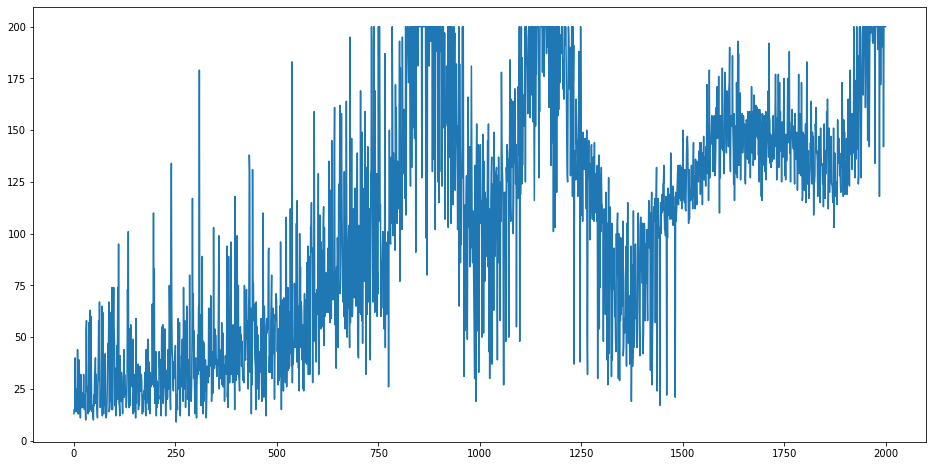

In [6]:
environment = gym.make('CartPole-v0')
tf.reset_default_graph()
session = tf.Session()
episodes = 2000
gamma = .99
batch = 10


policy = Policy(session, environment)

initial = tf.global_variables_initializer()
session.run(initial)

r = reinforce(environment, policy, episodes, batch, gamma)
plt.figure(figsize=(16,8))
plt.plot(r)
plt.show

# Actor-Critic on CartPole

In [2]:
class Actor():
    
    def __init__(self, session, numOfActions, numOfStates, lr):
        self.session = session #tensorflow session
        
        self.numOfActions = numOfActions
        self.numOfStates = numOfStates
        self.lr = lr
        
        self.current_state = tf.placeholder(tf.float32, [1, numOfStates], name='current_state')
        self.a = tf.placeholder(tf.int32, None, name='a')
        self.t = tf.placeholder(tf.float32, None, name='t')
        
        with tf.variable_scope('actor'):
            layer = tf.layers.dense(inputs=self.current_state, units=20, activation=tf.nn.relu, kernel_initializer=tf.random_normal_initializer(0.,.1), bias_initializer=tf.constant_initializer(.1), name = 'layer')
            self.probability = tf.layers.dense(inputs = layer, units=self.numOfActions, activation=tf.nn.softmax, kernel_initializer=tf.random_normal_initializer(0.,.1), bias_initializer=tf.constant_initializer(.1), name = 'prob')

        with tf.variable_scope('aprob'):
            aprob = tf.log(self.probability[0,self.a])
            self.tda = tf.reduce_mean(aprob * self.t)
            
        with tf.variable_scope('trainer'):
            self.trainer = tf.train.AdamOptimizer(self.lr).minimize(-self.tda)
        
    def update(self, s, a, t):
        current_state = s[np.newaxis, :]
        _, val = self.session.run([self.trainer, self.tda], feed_dict={self.current_state: current_state, self.a: a, self.t: t})
        return val

    
    def getAction(self, s):
        s = s[np.newaxis, :]
        p = self.session.run(self.probability, {self.current_state: s})
        a = np.random.choice(np.arange(p.shape[1]), p=p.ravel())
        return a

        
        

In [3]:
class Critic():
    
    def __init__(self, session, numOfStates, lr, gamma):
        self.session = session
        self.numOfState = numOfStates
        self.lr = lr
        self.gamma = gamma
        
        self.current_state = tf.placeholder(tf.float32, [1, self.numOfState], name='current_state')
        self.r = tf.placeholder(tf.float32, None, name='r')
        self.ns = tf.placeholder(tf.float32, [1,1], name='ns')
        

        with tf.variable_scope('critic'):

            layer = tf.layers.dense(inputs=self.current_state, units=20, activation=tf.nn.relu, kernel_initializer=tf.random_normal_initializer(0.,.1), bias_initializer=tf.constant_initializer(.1), name = 'layer')
            self.nns = tf.layers.dense(inputs=layer, units=1, activation=None, kernel_initializer=tf.random_normal_initializer(0.,.1), bias_initializer=tf.constant_initializer(.1), name='nns')
        with tf.variable_scope('squared_td'):
            self.td_err = self.r + self.gamma * self.ns - self.nns
            self.loss = tf.square(self.td_err)
        with tf.variable_scope('trainer'):
            self.trainer = tf.train.AdamOptimizer(self.lr).minimize(self.loss)

    
    def update(self, s, r, ns):
        current_state = s[np.newaxis, :]
        ns = ns[np.newaxis, :]
        
        value = self.session.run(self.nns, {self.current_state: ns})
        td_err, _ = self.session.run([self.td_err, self.trainer], {self.current_state: current_state, self.ns: value, self.r: r})
        
        return td_err
        

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.


/opt/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Instructions for updating:
Use tf.cast instead.


<function matplotlib.pyplot.show(*args, **kw)>

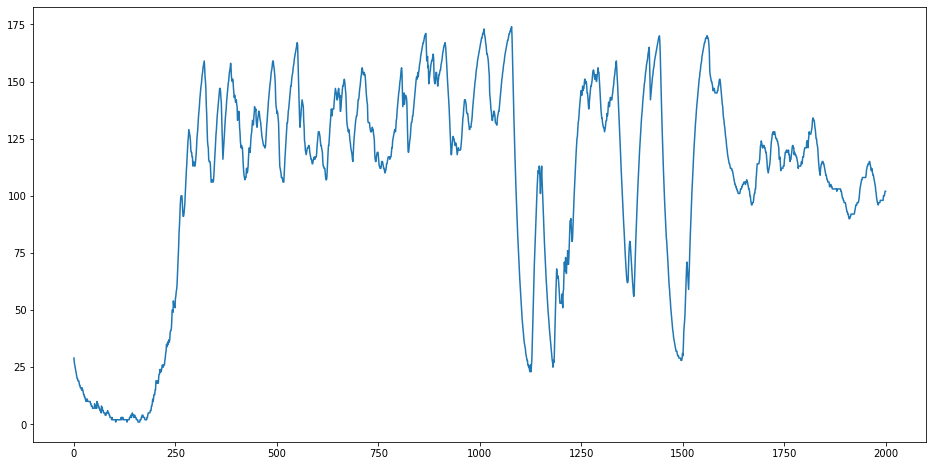

In [4]:
tf.reset_default_graph()

episodes = 2000
max_steps = 1000
gamma = 0.9     
actor_lr = 0.001    
critic_lr = 0.01     

env = gym.make('CartPole-v0')
numOfStates = env.observation_space.shape[0]
numOfActions = env.action_space.n


session = tf.Session()

actor = Actor(session, numOfActions, numOfStates, actor_lr)
critic = Critic(session, numOfStates, critic_lr, gamma)
session.run(tf.global_variables_initializer())
scores = []
episodess = []
for episode in range(episodes):
    current_state = env.reset()
    step = 0

    all_rewards = []
    while True:

        a = actor.getAction(current_state)

        ns, r, done, info = env.step(a)

        if done: r = -15

        all_rewards.append(r)

        td = critic.update(current_state, r, ns)
        actor.update(current_state, a, td)

        current_state = ns
        step += 1
        if done or step >= max_steps:
            episode_reward = sum(all_rewards)

            if 'all_reward' not in globals():
                all_reward = episode_reward
            else:
                all_reward = all_reward * 0.95 + episode_reward * 0.05
            if(all_reward >= 200):
                all_reward = 200
            episodess.append(episode)
            scores.append(int(all_reward))
            break
plt.figure(figsize=(16,8))
plt.plot(episodess, scores)
plt.show